In [1]:
!ls ../data/ -l

ls: 无法访问'../data/': 没有那个文件或目录


In [2]:
!ls ../data/训练集/

ls: 无法访问'../data/训练集/': 没有那个文件或目录


In [1]:
import pandas as pd
import cv2
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_df = pd.DataFrame({'path': glob.glob('./清华大学_智能硬件语音控制的时频图分类挑战赛/训练集/*/*')})
train_df['label'] = train_df['path'].apply(lambda x: int(x.split('/')[-2]))

In [15]:
train_df['label']

0       16
1       16
2       16
3       16
4       16
        ..
1862    15
1863    15
1864    15
1865    15
1866    15
Name: label, Length: 1867, dtype: int64

# 数据分析

In [4]:
def show_image(paths):
    plt.figure(figsize=(10, 8))
    for idx, path in enumerate(paths):
        plt.subplot(1, len(paths), idx+1)
        img = cv2.imread(path)
        print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])

(513, 800, 3)
(513, 800, 3)
(513, 800, 3)
(513, 800, 3)
(513, 800, 3)


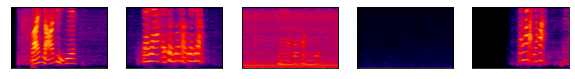

In [30]:
show_image(train_df.sample(5)['path'])

<AxesSubplot:>

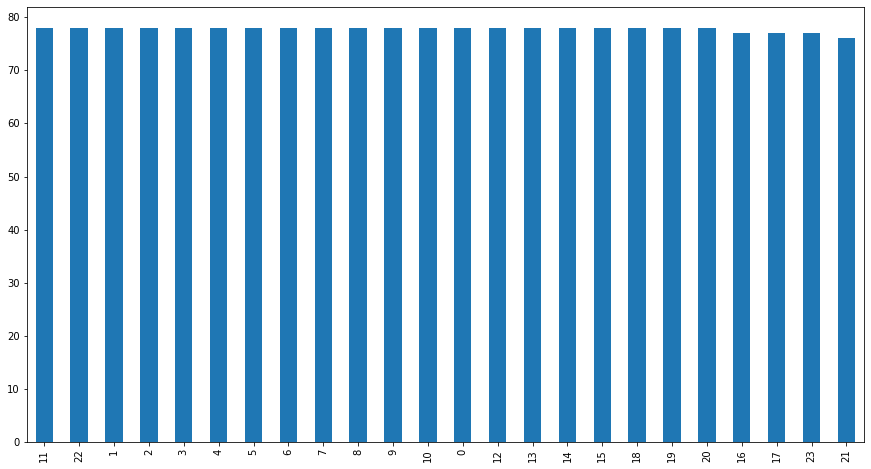

In [7]:
plt.figure(figsize=(15, 8))
train_df['label'].value_counts().plot(kind='bar')

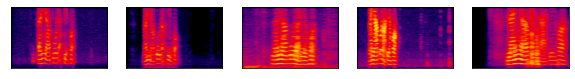

In [8]:
show_image(train_df[train_df['label'] == 1].sample(5)['path'])

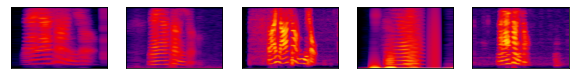

In [9]:
show_image(train_df[train_df['label'] == 10].sample(5)['path'])

# 模型训练

In [5]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [6]:
class XunFeiDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        self.transform = transform

    def __getitem__(self, index):
#         img = cv2.imread(self.img_path[index])[:, :, :3]
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = Image.open(self.img_path[index]).convert('RGB')
        img = np.asarray(img)
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        
        label = torch.from_numpy(np.array([self.img_label[index]]))
        return img, label

    def __len__(self):
        return len(self.img_path)

In [7]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        # print(correct.shape)
        res = []
        for k in topk:
            # print(correct[:k].shape)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size))
            
        # print(res)
        return res

In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
fold = 0
for train_idx, val_idx in skf.split(train_df['path'].values, train_df['label'].values):
    train_loader = torch.utils.data.DataLoader(
        XunFeiDataset(train_df['path'].iloc[train_idx][:100].values, train_df['label'].iloc[train_idx][:100].values,
                    A.Compose(
                        [
                            A.Resize(350, 350),
                            Transpose(),
                            OneOf([
                                IAAAdditiveGaussianNoise(),
                                GaussNoise(),
                            ], p=0.5),
#                             OneOf([
#                                 MotionBlur(p=0.2),
#                                 MedianBlur(blur_limit=3, p=0.1),
#                                 Blur(blur_limit=3, p=0.1),
#                             ], p=0.5),
                            OneOf([
                                OpticalDistortion(p=0.3),
                                GridDistortion(p=0.1),
                                IAAPiecewiseAffine(p=0.3),
                            ], p=0.5),
                            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                            A.RandomCrop(height=330, width=330),
                            A.RandomBrightnessContrast(p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2(),
                        ])
        ),
        batch_size=10, shuffle=True, num_workers=5,
    )

    val_loader = torch.utils.data.DataLoader(
        XunFeiDataset(train_df['path'].iloc[val_idx][:100].values, train_df['label'].iloc[val_idx][:100].values,
                    A.Compose(
                        [
                            A.Resize(330, 330),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2(),
                        ])
        ),
        batch_size=10, shuffle=False, num_workers=5,
    )
    
    import timm
    model = timm.create_model('efficientnet_b3', num_classes=24, pretrained=True, in_chans=3)

In [16]:
model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=len(train_loader) / 10, gamma=0.85)

print('Epoch/Batch\t\tTrain: loss/Top1/Top3\t\tTest: loss/Top1/Top3')

for epoch in range(5):
    train_losss, train_acc1s, train_acc5s = [], [], []
    for i, data in enumerate(train_loader):
        model = model.train()
        train_img, train_label = data
        optimizer.zero_grad()
        
        train_img = Variable(train_img).cuda()
        train_label = Variable(train_label.view(-1)).cuda()

        output = model(train_img)
        train_loss = loss_fn(output, train_label)
        
        train_loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_losss.append(train_loss.item())

        if i % int(100) == 0:
            val_losss, val_acc1s, val_acc5s = [], [], []
            
            with torch.no_grad():
                model.eval()
                train_acc1, train_acc3 = accuracy(output, train_label, topk=(1, 3))
                train_acc1s.append(train_acc1.data.item())
                train_acc5s.append(train_acc3.item())
            
                for data in val_loader:
                    val_images, val_labels = data
                    
                    # val_images = Variable(val_images).cuda(async=True)
                    # val_labels = Variable(val_labels.view(-1)).cuda()

                    val_images = Variable(val_images).cuda()
                    val_labels = Variable(val_labels.view(-1)).cuda() 
                    
                    output = model(val_images)
                    val_loss = loss_fn(output, val_labels)
                    val_acc1, val_acc3 = accuracy(output, val_labels, topk=(1, 3))
                    
                    val_losss.append(val_loss.item())
                    val_acc1s.append(val_acc1.item())
                    val_acc5s.append(val_acc3.item())
                    
            logstr = '{0:2s}/{1:6s}\t\t{2:.4f}/{3:.4f}/{4:.4f}\t\t{5:.4f}/{6:.4f}/{7:.4f}'.format(
                    str(epoch), str(i),
                    np.mean(train_losss, 0), np.mean(train_acc1s, 0), np.mean(train_acc5s, 0),
                    np.mean(val_losss, 0), np.mean(val_acc1s, 0), np.mean(val_acc5s, 0),
                )
            torch.save(model.state_dict(), 'model_{0}.pt'.format(epoch))
            print(logstr)
            logging.info(logstr)

Epoch/Batch		Train: loss/Top1/Top3		Test: loss/Top1/Top3
0 /0     		0.9141/30.0000/100.0000		4128943078.4000/16.0000/31.0000
1 /0     		0.5022/80.0000/100.0000		36945.8771/16.0000/31.0000
2 /0     		0.6141/80.0000/100.0000		329.4372/15.0000/51.0000
3 /0     		0.6455/50.0000/100.0000		36.2436/13.0000/41.0000
4 /0     		0.7294/40.0000/100.0000		25.4556/20.0000/46.0000


In [17]:
test_df = pd.DataFrame({'path': glob.glob('./清华大学_智能硬件语音控制的时频图分类挑战赛/测试集/*')})
test_df['label'] = 0

In [18]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_df['path'].values[:], test_df['label'].values[:],
                    A.Compose(
                        [
                            A.Resize(330, 330),
                            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2(),
                        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [19]:
pred_tta = []
for tti in range(5):
    pred = []
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x).cuda(async=True)
            y_var = Variable(y).cuda()
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)    
    print(tti)
    pred_tta.append(pred)

pred = np.mean(pred_tta, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  


0
1
2
3
4


In [22]:
test_df['category_id'] = pred.argmax(1)
test_df['image_id'] = test_df['path'].apply(lambda x: x.split('/')[-1])

In [23]:
test_df[['image_id','category_id']].to_csv('submit113.csv', index=None)